## 基于sklearn糖尿病数据集（diabetes）的线性回归模型和深度神经网络模型的对比

### diabetes 是一个关于糖尿病的数据集， 该数据集包括442个病人的生理数据及一年以后的病情发展情况。   
#### 数据集中的特征值总共10项, 如下:  
#### ['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6']
年龄  
性别  
体质指数  
血压  
s1,s2,s3,s4,s4,s6  (六种血清的化验数据)  
target 为糖尿病进展的数据
#### 但请注意，以上的数据是经过特殊处理，10个特征的数据中的每个都做了均值中心化处理，然后又用标准差乘以个体数量调整了数值范围。验证就会发现任何一列的所有数值平方和为1. 

In [1]:
import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
import matplotlib.pyplot as plt
import numpy as np  
import pandas as pd
from sklearn import datasets
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### 添加数据集

In [2]:
diabetes = datasets.load_diabetes()  

In [3]:
#查看数据量
len(diabetes.data[:,0])

442

In [4]:
diabetes.data[0,:]

array([ 0.03807591,  0.05068012,  0.06169621,  0.02187235, -0.0442235 ,
       -0.03482076, -0.04340085, -0.00259226,  0.01990842, -0.01764613])

In [5]:
#求证： 每一列的数值的平方和为1  
np.sum( diabetes.data[:,0]**2)  #求年龄列  

1.0000000000000746

In [6]:
np.sum(diabetes.data[:,3])

5.700995231450179e-14

In [7]:
df_diabetes = pd.DataFrame(diabetes.data,columns = diabetes.feature_names)
df_diabetes['target'] = pd.Series(diabetes.target)

In [8]:
df_diabetes.head()#查看前五行数据

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930,141.0
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022692,-0.009362,206.0
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031991,-0.046641,135.0


In [9]:
df_diabetes.describe() #共有442条数据 需要预测的target糖尿病进展的数据在25-346之间

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
count,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,442.000000
mean,-3.639623e-16,1.309912e-16,-8.013951e-16,1.289818e-16,-9.042540e-17,1.301121e-16,-4.563971e-16,3.863174e-16,-3.848103e-16,-3.398488e-16,152.133484
std,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,77.093005
min,-1.072256e-01,-4.464164e-02,-9.027530e-02,-1.123996e-01,-1.267807e-01,-1.156131e-01,-1.023071e-01,-7.639450e-02,-1.260974e-01,-1.377672e-01,25.000000
25%,-3.729927e-02,-4.464164e-02,-3.422907e-02,-3.665645e-02,-3.424784e-02,-3.035840e-02,-3.511716e-02,-3.949338e-02,-3.324879e-02,-3.317903e-02,87.000000
50%,5.383060e-03,-4.464164e-02,-7.283766e-03,-5.670611e-03,-4.320866e-03,-3.819065e-03,-6.584468e-03,-2.592262e-03,-1.947634e-03,-1.077698e-03,140.500000
75%,3.807591e-02,5.068012e-02,3.124802e-02,3.564384e-02,2.835801e-02,2.984439e-02,2.931150e-02,3.430886e-02,3.243323e-02,2.791705e-02,211.500000
max,1.107267e-01,5.068012e-02,1.705552e-01,1.320442e-01,1.539137e-01,1.987880e-01,1.811791e-01,1.852344e-01,1.335990e-01,1.356118e-01,346.000000


In [10]:
diabetes_dataframe = df_diabetes
#打乱数据的原有次序，随机重排
diabetes_dataframe = diabetes_dataframe.reindex(np.random.permutation(diabetes_dataframe.index))

In [11]:
def preprocess_features(diabetes_dataframe):
  selected_features = diabetes_dataframe[["age", "sex", "bmi", "bp", "s1", "s2", "s3", "s4", "s5", "s6" ]]
  processed_features = selected_features.copy()
  return processed_features

def preprocess_targets(diabetes_dataframe):
  output_targets = pd.DataFrame()
  output_targets["target"] = diabetes_dataframe["target"]
  return output_targets

生成数据样本，包括训练样本和测试样本

In [12]:
training_examples = preprocess_features(diabetes_dataframe.head(310))
training_targets = preprocess_targets(diabetes_dataframe.head(310))

validation_examples = preprocess_features(diabetes_dataframe.tail(132))
validation_targets = preprocess_targets(diabetes_dataframe.tail(132))

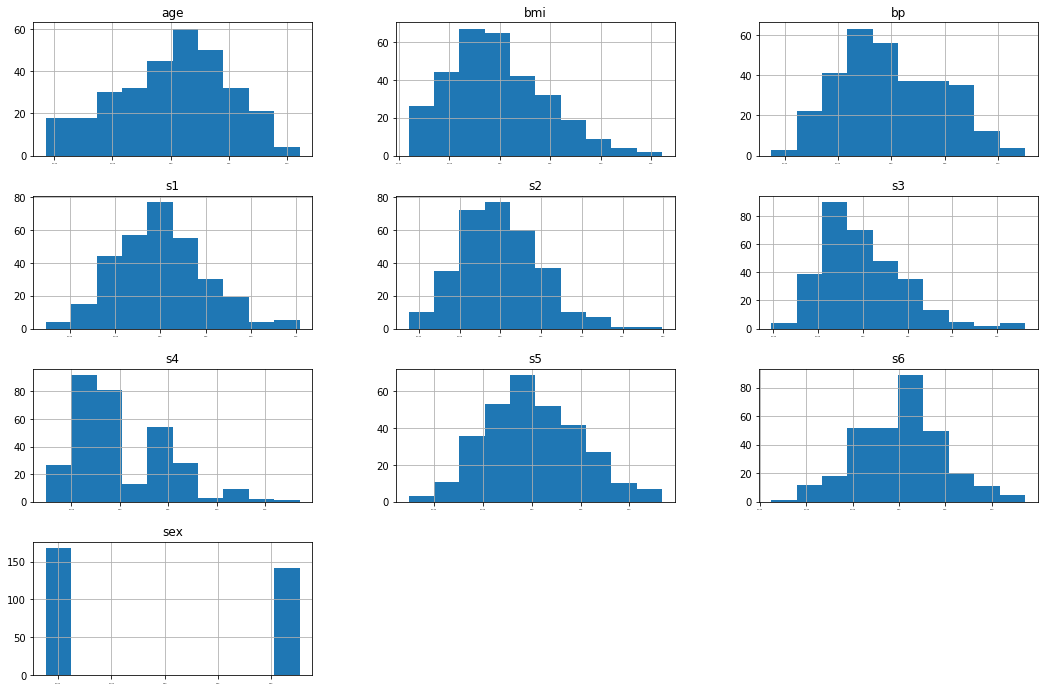

In [13]:
_ = training_examples.hist(bins=10, figsize=(18, 12), xlabelsize=2)

相关矩阵展现了两两比较的相关性，既包括每个特征与目标特征之间的比较，也包括每个特征与其他特征之间的比较。

在这里，相关性被定义为皮尔逊相关系数。相关性值具有以下含义：

-1.0：完全负相关
0.0：不相关
1.0：完全正相关

In [14]:
correlation_dataframe = training_examples.copy()
correlation_dataframe["target"] = training_targets["target"]

correlation_dataframe.corr()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
age,1.000000,0.162033,0.233074,0.328500,0.240226,0.218646,-0.110868,0.213303,0.249366,0.393687,0.171379
sex,0.162033,1.000000,0.130376,0.252065,0.033959,0.159152,-0.401166,0.347685,0.114457,0.219579,0.055871
bmi,0.233074,0.130376,1.000000,0.390107,0.282548,0.295479,-0.401793,0.467165,0.464951,0.403271,0.587223
bp,0.328500,0.252065,0.390107,1.000000,0.268726,0.199994,-0.154207,0.273676,0.385835,0.429932,0.422593
s1,0.240226,0.033959,0.282548,0.268726,1.000000,0.896332,0.030841,0.578049,0.526988,0.360503,0.200778
s2,0.218646,0.159152,0.295479,0.199994,0.896332,1.000000,-0.200145,0.674704,0.315815,0.322681,0.158552
s3,-0.110868,-0.401166,-0.401793,-0.154207,0.030841,-0.200145,1.000000,-0.724055,-0.401555,-0.271204,-0.403115
s4,0.213303,0.347685,0.467165,0.273676,0.578049,0.674704,-0.724055,1.000000,0.627866,0.442651,0.426916
s5,0.249366,0.114457,0.464951,0.385835,0.526988,0.315815,-0.401555,0.627866,1.000000,0.472377,0.559125
s6,0.393687,0.219579,0.403271,0.429932,0.360503,0.322681,-0.271204,0.442651,0.472377,1.000000,0.373874


生成特征列，自定义数据输入

In [15]:
def construct_feature_columns(input_features):
  return set([tf.feature_column.numeric_column(my_feature)
              for my_feature in input_features])

In [16]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    # Convert pandas data into a dict of np arrays.
    features = {key:np.array(value) for key,value in dict(features).items()}                                             
 
    # Construct a dataset, and configure batching/repeating
    ds = Dataset.from_tensor_slices((features,targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    # Shuffle the data, if specified
    if shuffle:
      ds = ds.shuffle(10000)
    
    # Return the next batch of data
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

### 构建线性回归模型

In [17]:
def train_model( learning_rate,  steps,  batch_size,  
                 training_examples,  training_targets,  validation_examples,  validation_targets):

  periods = 10
  steps_per_period = steps / periods
  #print(training_examples)
  #print(validation_examples)
  
  my_optimizer = tf.train.AdagradOptimizer(learning_rate=learning_rate)
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
  linear_regressor = tf.estimator.LinearRegressor(
      feature_columns=construct_feature_columns(training_examples),
      optimizer=my_optimizer
  )
    
  # Create input functions
  training_input_fn = lambda: my_input_fn(training_examples, 
                                          training_targets["target"], 
                                          batch_size=batch_size)
  predict_training_input_fn = lambda: my_input_fn(training_examples, 
                                                  training_targets["target"], 
                                                  num_epochs=1, 
                                                  shuffle=False)
  predict_validation_input_fn = lambda: my_input_fn(validation_examples, 
                                                    validation_targets["target"], 
                                                    num_epochs=1, 
                                                    shuffle=False)

  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  print( "Training model...")
  print( "RMSE (on training data):")
  training_rmse = []
  validation_rmse = []
  for period in range (0, periods):
    # Train the model, starting from the prior state.
    linear_regressor.train(
        input_fn=training_input_fn,
        steps=steps_per_period,
    )
    # Take a break and compute predictions.
    training_predictions = linear_regressor.predict(input_fn=predict_training_input_fn)
    training_predictions = np.array([item['predictions'][0] for item in training_predictions])
    
    validation_predictions = linear_regressor.predict(input_fn=predict_validation_input_fn)
    validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])
    
    # Compute training and validation loss.
    training_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(training_predictions, training_targets))
    validation_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(validation_predictions, validation_targets))
    # Occasionally print the current loss.
    print( "  period %02d : %0.2f" % (period, training_root_mean_squared_error))
    # Add the loss metrics from this period to our list.
    training_rmse.append(training_root_mean_squared_error)
    validation_rmse.append(validation_root_mean_squared_error)
  print( "Model training finished.")

  
  # Output a graph of loss metrics over periods.
  plt.ylabel("RMSE")
  plt.xlabel("Periods")
  plt.title("Root Mean Squared Error vs. Periods")
  plt.tight_layout()
  plt.plot(training_rmse, 'r:', label="training")
  plt.plot(validation_rmse, 'b-',label="validation")
  plt.legend()

  return linear_regressor

### 训练线性回归模型

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_num_ps_replicas': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f25b7e2d2b0>, '_task_type': 'worker', '_keep_checkpoint_every_n_hours': 10000, '_master': '', '_save_summary_steps': 100, '_model_dir': '/tmp/tmp8t5cr5sn', '_session_config': None, '_tf_random_seed': None, '_save_checkpoints_steps': None, '_keep_checkpoint_max': 5, '_num_worker_replicas': 1, '_task_id': 0, '_log_step_count_steps': 100, '_is_chief': True, '_save_checkpoints_secs': 600, '_service': None}
Training model...
RMSE (on training data):
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into /tmp/tmp8t5cr5sn/model.ckpt.
INFO:tensorflow:step = 1, loss = 2691634.0
INFO:tensorflow:global_step/sec: 419.667
INFO:tensorflow:step = 101, loss = 2858648.0 (0.243 sec)
INFO:tensorflow:Saving checkpoints for 200 into /tmp/tmp8t5cr5sn/model.ckpt.
INFO:tensorflow:Loss for final step: 3514

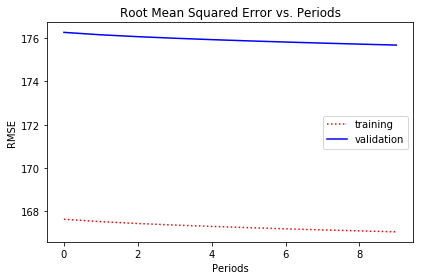

In [18]:
_ = train_model(
    learning_rate=0.01,
    steps=2000,
    batch_size=100,
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

### 构建神经网络

In [19]:
def train_nn_regression_model( learning_rate, steps, batch_size, hidden_units,
    training_examples, training_targets, validation_examples, validation_targets):

  periods = 10
  steps_per_period = steps / periods
  
  # Create a linear regressor object.
  my_optimizer = tf.train.AdagradOptimizer(learning_rate=learning_rate)#采用AdagradOptimizer优化器
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
  dnn_regressor = tf.estimator.DNNRegressor(
      feature_columns=construct_feature_columns(training_examples),
      hidden_units=hidden_units
  )
  
  # Create input functions
  training_input_fn = lambda: my_input_fn(training_examples, 
                                          training_targets["target"], 
                                          batch_size=batch_size)
  predict_training_input_fn = lambda: my_input_fn(training_examples, 
                                                  training_targets["target"], 
                                                  num_epochs=1, 
                                                  shuffle=False)
  predict_validation_input_fn = lambda: my_input_fn(validation_examples, 
                                                    validation_targets["target"], 
                                                    num_epochs=1, 
                                                    shuffle=False)

  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  print("Training model...")
  print("RMSE (on training data):")
  training_rmse = []
  validation_rmse = []
  for period in range (0, periods):
    # Train the model, starting from the prior state.
    dnn_regressor.train(
        input_fn=training_input_fn,
        steps=steps_per_period
    )
    # Take a break and compute predictions.
    training_predictions = dnn_regressor.predict(input_fn=predict_training_input_fn)
    training_predictions = np.array([item['predictions'][0] for item in training_predictions])
    
    validation_predictions = dnn_regressor.predict(input_fn=predict_validation_input_fn)
    validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])
    
    # Compute training and validation loss.
    training_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(training_predictions, training_targets))
    validation_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(validation_predictions, validation_targets))
    # Occasionally print the current loss.
    print("  period %02d : %0.2f" % (period, training_root_mean_squared_error))
    # Add the loss metrics from this period to our list.
    training_rmse.append(training_root_mean_squared_error)
    validation_rmse.append(validation_root_mean_squared_error)
  print("Model training finished.")

  # Output a graph of loss metrics over periods.
  plt.ylabel("RMSE")
  plt.xlabel("Periods")
  plt.title("Root Mean Squared Error vs. Periods")
  plt.tight_layout()
  plt.plot(training_rmse, label="training")
  plt.plot(validation_rmse, label="validation")
  plt.legend()

  print("Final RMSE (on training data):   %0.2f" % training_root_mean_squared_error)
  print("Final RMSE (on validation data): %0.2f" % validation_root_mean_squared_error)

  return dnn_regressor

### 训练神经网络模型

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_num_ps_replicas': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f25a61bdac8>, '_task_type': 'worker', '_keep_checkpoint_every_n_hours': 10000, '_master': '', '_save_summary_steps': 100, '_model_dir': '/tmp/tmp_jr_4lba', '_session_config': None, '_tf_random_seed': None, '_save_checkpoints_steps': None, '_keep_checkpoint_max': 5, '_num_worker_replicas': 1, '_task_id': 0, '_log_step_count_steps': 100, '_is_chief': True, '_save_checkpoints_secs': 600, '_service': None}
Training model...
RMSE (on training data):
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into /tmp/tmp_jr_4lba/model.ckpt.
INFO:tensorflow:step = 1, loss = 2829010.0
INFO:tensorflow:global_step/sec: 461.625
INFO:tensorflow:step = 101, loss = 486425.75 (0.220 sec)
INFO:tensorflow:Saving checkpoints for 200 into /tmp/tmp_jr_4lba/model.ckpt.
INFO:tensorflow:Loss for final step: 3629

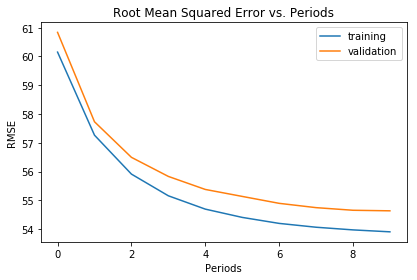

In [20]:
dnn_regressor = train_nn_regression_model(
    learning_rate=0.01,
    steps=2000,
    batch_size=100,
    hidden_units=[10,10],#两个隐藏层，都是10个节点
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

setps = 4000 ;隐藏层增加了一层（10个节点）

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_num_ps_replicas': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f25a6868e10>, '_task_type': 'worker', '_keep_checkpoint_every_n_hours': 10000, '_master': '', '_save_summary_steps': 100, '_model_dir': '/tmp/tmpl3w6jmit', '_session_config': None, '_tf_random_seed': None, '_save_checkpoints_steps': None, '_keep_checkpoint_max': 5, '_num_worker_replicas': 1, '_task_id': 0, '_log_step_count_steps': 100, '_is_chief': True, '_save_checkpoints_secs': 600, '_service': None}
Training model...
RMSE (on training data):
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into /tmp/tmpl3w6jmit/model.ckpt.
INFO:tensorflow:step = 1, loss = 352389.8
INFO:tensorflow:global_step/sec: 462.892
INFO:tensorflow:step = 101, loss = 30975.115 (0.221 sec)
INFO:tensorflow:global_step/sec: 552.215
INFO:tensorflow:step = 201, loss = 267646.94 (0.180 sec)
INFO:tensorflow:globa

INFO:tensorflow:Saving checkpoints for 3601 into /tmp/tmpl3w6jmit/model.ckpt.
INFO:tensorflow:step = 3601, loss = 277173.1
INFO:tensorflow:global_step/sec: 452.546
INFO:tensorflow:step = 3701, loss = 334624.47 (0.225 sec)
INFO:tensorflow:global_step/sec: 594.086
INFO:tensorflow:step = 3801, loss = 252874.38 (0.168 sec)
INFO:tensorflow:global_step/sec: 585.347
INFO:tensorflow:step = 3901, loss = 333524.1 (0.171 sec)
INFO:tensorflow:Saving checkpoints for 4000 into /tmp/tmpl3w6jmit/model.ckpt.
INFO:tensorflow:Loss for final step: 274014.88.
INFO:tensorflow:Restoring parameters from /tmp/tmpl3w6jmit/model.ckpt-4000
INFO:tensorflow:Restoring parameters from /tmp/tmpl3w6jmit/model.ckpt-4000
  period 09 : 53.17
Model training finished.
Final RMSE (on training data):   53.17
Final RMSE (on validation data): 54.11


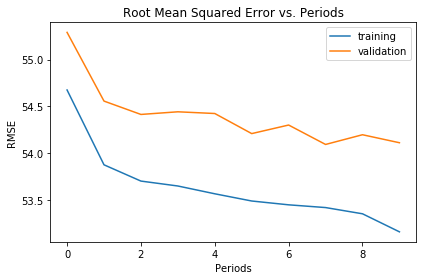

In [23]:
dnn_regressor = train_nn_regression_model(
    learning_rate=0.01,
    steps=4000,#4000步
    batch_size=100,
    hidden_units=[10,10,10],#三个隐藏层，都是10个节点
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

learning_rate = 0.005，隐藏层再增加一层

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_num_ps_replicas': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f25a61057f0>, '_task_type': 'worker', '_keep_checkpoint_every_n_hours': 10000, '_master': '', '_save_summary_steps': 100, '_model_dir': '/tmp/tmpwygxq0rf', '_session_config': None, '_tf_random_seed': None, '_save_checkpoints_steps': None, '_keep_checkpoint_max': 5, '_num_worker_replicas': 1, '_task_id': 0, '_log_step_count_steps': 100, '_is_chief': True, '_save_checkpoints_secs': 600, '_service': None}
Training model...
RMSE (on training data):
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into /tmp/tmpwygxq0rf/model.ckpt.
INFO:tensorflow:step = 1, loss = 352430.12
INFO:tensorflow:global_step/sec: 460.658
INFO:tensorflow:step = 101, loss = 326223.12 (0.221 sec)
INFO:tensorflow:global_step/sec: 582.216
INFO:tensorflow:step = 201, loss = 349192.22 (0.172 sec)
INFO:tensorflow:glob

INFO:tensorflow:Saving checkpoints for 3601 into /tmp/tmpwygxq0rf/model.ckpt.
INFO:tensorflow:step = 3601, loss = 235028.6
INFO:tensorflow:global_step/sec: 445.974
INFO:tensorflow:step = 3701, loss = 15711.849 (0.228 sec)
INFO:tensorflow:global_step/sec: 581.855
INFO:tensorflow:step = 3801, loss = 321651.12 (0.172 sec)
INFO:tensorflow:global_step/sec: 580.241
INFO:tensorflow:step = 3901, loss = 267084.3 (0.173 sec)
INFO:tensorflow:Saving checkpoints for 4000 into /tmp/tmpwygxq0rf/model.ckpt.
INFO:tensorflow:Loss for final step: 236149.08.
INFO:tensorflow:Restoring parameters from /tmp/tmpwygxq0rf/model.ckpt-4000
INFO:tensorflow:Restoring parameters from /tmp/tmpwygxq0rf/model.ckpt-4000
  period 09 : 52.09
Model training finished.
Final RMSE (on training data):   52.09
Final RMSE (on validation data): 53.90


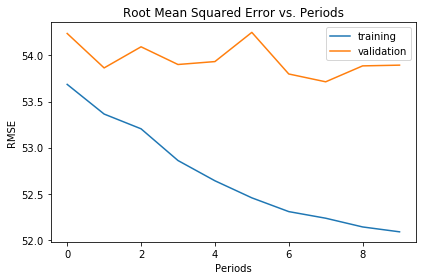

In [32]:
dnn_regressor = train_nn_regression_model(
    learning_rate=0.005,
    steps=4000,
    batch_size=100,
    hidden_units=[10,10,10,10],#四个隐藏层，都是10个节点
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)